# Пример обработки серии экспериментальных кинетических кривых в DynaFit


## Импортируем необходимые библиотеки
Для работы нужно установить следующие пакеты: `pandas`, `matplotlib`, `scikit-learn`
Это можно сделать, выполнив команду

In [1]:
import sys
import os
import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.cm import get_cmap

from collections import defaultdict

import sklearn.cluster as cl
from sklearn.manifold import TSNE

Файлы с оптимизированными параметрами, обычно называются так (если при оптимизации использовался метод `TR`). Их и будем искать в выводе DynaFit.

In [2]:
PARFILE = "parameters-t001-TR.txt"

Служебные функции для доступа к коллекциям

In [3]:
def get(index, default=None):
    """ A getter factory for dictionary lookup function 
    """
    def __get(seq):
        try:
            # Если нашли ключ в словаре или списке, возвращаем значение
            result = seq[index]
        except Exception:
            # Если не нашли, возвращаем :default
            result = default
        return result
    # Возвращаем функцию-геттер
    return __get

def gen_val(num=None):
    """ A factory of constant value function
    """
    def constant():
        return num
    return constant

Функция, собирающая параметры из разрозненных результатов DynaFit, находящихся в папке `data_dir` в одну таблицу
> !TODO
> Здесь, по-хорошему, нужно написать настоящий парсер выходных файлов, но эту задачу я не осилил, поэтому функция `get_parameters` может работать нестабильно. В случае проблем пишите moleculadesigner@gmail.com

In [7]:
def get_parameters(data_dir):
    # Собираем все папки вида /data_dir/abc/txt
    data_point_re = re.compile(
        f"{data_dir}/(?P<exp_id>[a-z]{{3}})/txt"
    )
    parameter_re = re.compile(
        r"^k.+$|^r\(.+$",
        re.I
    )
    dirs = [
        data_point
        for data_point in map(
            get(0), 
            os.walk(data_dir)
        )
        if data_point_re.match(data_point)
    ]
    
    # Разбираем параметры
    parameters = []
    for experiment in dirs:
        record = defaultdict(gen_val(np.nan))
        path = f"{experiment}/{PARFILE}"
        exp_id = data_point_re.match(experiment).group("exp_id")
        
        record["exp_id"] = exp_id
        if not os.path.isfile(path):
            continue
            
        with open(path, "r") as f:
            for line in f.readlines():
                tokens = line.strip().split()
                if len(tokens) > 3 and parameter_re.match(tokens[2]):
                    par_name = tokens[2]
                    init = tokens[3]
                    try:
                        final = tokens[6]
                    except IndexError:
                        final = np.nan
                else:
                    continue
                record[f"{par_name}.init"] = float(init)
                record[f"{par_name}.final"] = float(final)
        parameters.append(record)

    data = pd.DataFrame.from_records(parameters)
    
    return data

Функция рисует диаграмму распределения начальных и конечных значений выбранной константы (`constant_name`)

In [8]:
def draw_constant(df, constant_name):
    fig, ax = plt.subplots(figsize=(5, 4))
    plt.scatter(
        df[f"{constant_name}.init"],
        df[f"{constant_name}.final"],
        s=6
    )
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylim(5e-7, 5e+6)
    ax.set_xlim(5e-7, 6e+6)
    ax.set_xlabel(f"{constant_name}.init", fontsize=14)
    ax.set_ylabel(f"{constant_name}.final", fontsize=14)

---

# Исследуем результаты множества оптимизаций

## 2-stage mechanism
Сначала рассмотрим минимальный случай – аппроксимацию двухстадийным механизмом

$$
\mathrm{E} + \mathrm{S}
\begin{matrix}
k_1 \\
\leftrightarrows \\
k_{-1}
\end{matrix}
\mathrm{ES}
\begin{matrix}
k_{cat} \\
\rightarrow \\
\\
\end{matrix}
\mathrm{EP}
$$

Загружаем все результаты:

In [9]:
# В этой папке лежат результаты
# множества случайных симуляций DynaFit
data_dir2 = "../data/u-trp/2-stage/random-many"
data2 = get_parameters(data_dir2)
data2.head()

exp_id       k.1.init     k.1.final     k.-1.init   k.-1.final  \
0    gba       0.000102      14.56250      0.018332      8.89687   
1    eac       0.000023      48.30460  35085.300000  35081.30000   
2    agg       0.000005      22.69610  15739.000000  15739.00000   
3    cde       0.000066       6.94602     57.008100      4.97120   
4    ahc  580248.000000  580248.00000    479.611000    479.52000   

      k.cat.init    k.cat.final  r(E).init  r(E).final  r(S).init  r(S).final  \
0  828943.000000  828943.000000       0.31    0.664030        0.0         NaN   
1   15226.500000   15215.000000       0.31    0.518316        0.0         NaN   
2       2.243640       9.751300       0.31    4.318450        0.0         NaN   
3       0.082391       0.009633       0.31    0.770620        0.0         NaN   
4       0.000001       0.010130       0.31    3.436630        0.0         NaN   

   r(E.S1).init  r(E.S1).final  r(E.P).init  r(E.P).final  
0          0.22   2.200000e-07         0.25  6.011820e-01  
1          0.22   2.473840e-01         0.25  4.550970e-01  
2          0.22   2.200000e-07         0.25  4.297040e+00  
3          0.22   6.749220e-01         0.25  7.106010e-01  
4          0.22   1.755890e-03         0.25  2.500000e-07

## Графики для индивидуальных констант
### $k_1$

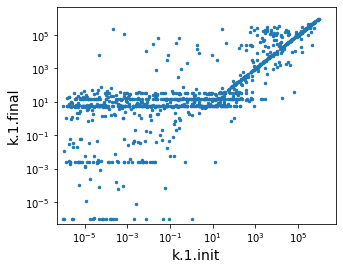

In [7]:
draw_constant(
    data2,
    "k.1",
)

### $k_{-1}$

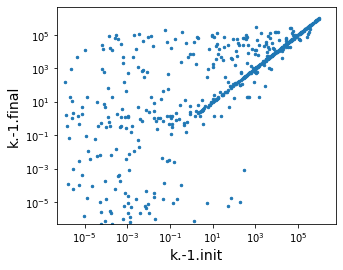

In [8]:
draw_constant(
    data2,
    "k.-1",
)

Видим, что на графике $k_{-1}$ нет устойчивых решений

### $k_{cat}$

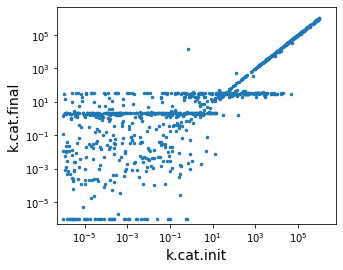

In [9]:
draw_constant(
    data2,
    "k.cat",
)

Так как для одной из констант не наблюдалось устойчивого решения, увеличим количество стадий в механизме.

## 3-stage mechanism
Рассмотрим успешный случай – аппроксимацию трехстадийным механизмом

$$
\mathrm{E} + \mathrm{S}
\begin{matrix}
k_1 \\
\leftrightarrows \\
k_{-1}
\end{matrix}
\mathrm{ES}_1
\begin{matrix}
k_2 \\
\leftrightarrows \\
k_{-2}
\end{matrix}
\mathrm{ES}_2 
\begin{matrix}
k_{cat} \\
\rightarrow \\
\\
\end{matrix}
\mathrm{EP}
$$

Загружаем все результаты:

In [10]:
# В этой папке лежат результаты
# множества случайных симуляций DynaFit
data_dir3 = "../data/u-trp/3-stage/random-many"
data3 = get_parameters(data_dir3)
data3.head()

exp_id       k.1.init      k.1.final  k.-1.init  k.-1.final     k.2.init  \
0    gba       0.000006      13.186200   0.000005    0.000036  6628.000000   
1    eac  100100.000000  100100.000000   0.000053    0.113249     0.007432   
2    agg    2399.000000     239.419000   4.313000  144.221000     0.000076   
3    cde       0.000008       0.000001   0.000134    0.000001     0.037740   
4    ahc       0.000128       5.470330   2.715000    0.000248     0.000618   

     k.2.final   k.-2.init  k.-2.final     k.cat.init  ...  r(E).init  \
0  6627.930000  520.600000  520.601000  608100.000000  ...       0.85   
1     0.000151   27.840000   27.839900    2746.000000  ...       0.85   
2    14.686400    1.418000    0.000001       0.000003  ...       0.85   
3     0.000001    0.025170    1.622870    1602.000000  ...       0.85   
4     1.573650    0.000016    0.000147    5205.000000  ...       0.85   

   r(E).final  r(S).init  r(S).final  r(E.S1).init  r(E.S1).final  \
0    0.850406        0.0         NaN          0.83       3.573680   
1    0.973416        0.0         NaN          0.83       0.671114   
2    0.860636        0.0         NaN          0.83       0.844846   
3    0.692227        0.0         NaN          0.83     172.515000   
4    0.840357        0.0         NaN          0.83       0.751558   

   r(E.S2).init  r(E.S2).final  r(E.P).init  r(E.P).final  
0          0.75       0.826873         0.81      0.792122  
1          0.75       0.738899         0.81      2.464040  
2          0.75       0.763738         0.81      0.803516  
3          0.75       0.748545         0.81     22.935200  
4          0.75       0.750084         0.81      0.791277  

[5 rows x 21 columns]

## Графики для индивидуальных констант
### $k_1$

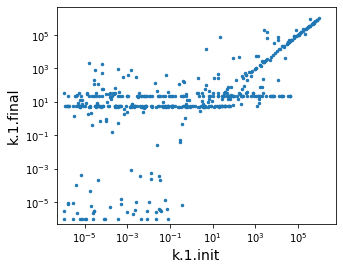

In [11]:
draw_constant(
    data3,
    "k.1",
)

### $k_{-1}$

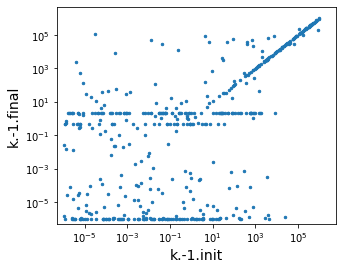

In [12]:
draw_constant(
    data3,
    "k.-1",
)

### $k_2$

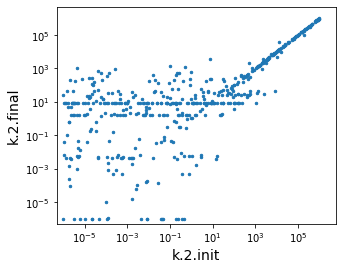

In [13]:
draw_constant(
    data3,
    "k.2",
)

### $k_{-2}$

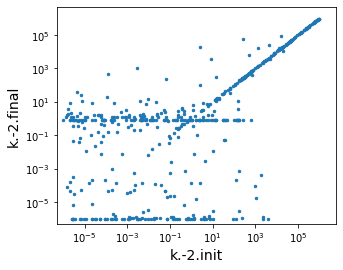

In [14]:
draw_constant(
    data3,
    "k.-2",
)

### $k_{cat}$

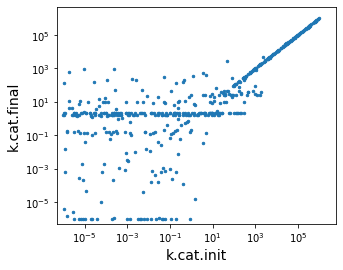

In [15]:
draw_constant(
    data3,
    "k.cat",
)

## Исследуем попарные комбинации констант

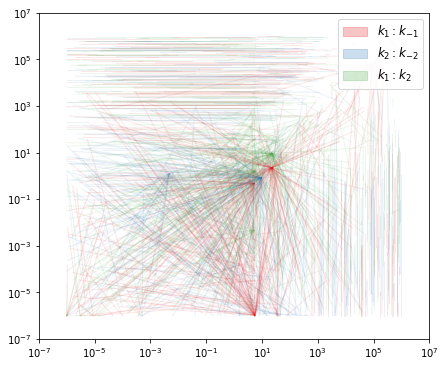

In [16]:
fig, ax = plt.subplots(figsize=(7, 6))

# Цвета отдельных серий
palette = [
    "#e41a1c",
    "#377eb8",
    "#4daf4a",
]

# Рисуем пары
for i, point in data3.iterrows():
    plt.plot(
        point[["k.1.init", "k.1.final"]],
        point[["k.-1.init", "k.-1.final"]],
        c=palette[0],
        alpha=0.1,
        linewidth=1,
    )

    plt.plot(
        point[["k.2.init", "k.2.final"]],
        point[["k.-2.init", "k.-2.final"]],
        c=palette[1],
        alpha=0.1,
        linewidth=1,

    )

    plt.plot(
        point[["k.1.init", "k.1.final"]],
        point[["k.2.init", "k.2.final"]],
        c=palette[2],
        alpha=0.1,
        linewidth=1,
    )

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(1e-7, 1e+7)
ax.set_xlim(1e-7, 1e+7)

# Рисуем легенду
patches = [
    mpatches.Patch(
        color=palette[0],
        alpha=0.25,
        label="$k_1 : k_{-1}$",
    ),
    mpatches.Patch(
        color=palette[1],
        alpha=0.25,
        label="$k_2 : k_{-2}$",
    ),
    mpatches.Patch(
        color=palette[2],
        alpha=0.25,
        label="$k_1 : k_2$",
    ),
]
ax.legend(handles=patches, fontsize=12);

На диаграмме видны устойчивые комбинации конечных значений констант скорости

---

## Кластеризация пространства решений
Для поиска устойчивых комбинаций оптимизированных параметров используем алгоритм [DBSCAN](https://ru.wikipedia.org/wiki/DBSCAN) – он находит плотные скопления точек в многомерном пространстве. Преимущества алгоритма в том, что нам не нужно заранее знать количество кластеров решений.

Параметры кластеризации

In [17]:
dbscan_params = {
    "eps": 0.5,       # предел расстояния между элементами в кластере
    "min_samples": 4, # минимальное количество элементов в кластере
}

Выделяем в таблице только колонки с финальными значениями констант и респонсов

In [18]:
columns_to_clusters = data3.iloc[:,2:21:2].dropna(axis=1).columns
columns_to_clusters

Index(['k.1.final', 'k.-1.final', 'k.2.final', 'k.-2.final', 'k.cat.final',
       'r(E).final', 'r(E.S1).final', 'r(E.S2).final', 'r(E.P).final'],
      dtype='object')

Кластеризуем пространство решений

In [19]:
dbscan3 = cl.DBSCAN(**dbscan_params)
dbscan3.fit(
    np.log10(
        # логарифм позволяет лучше различать константы с небольшими значениями
        data3[columns_to_clusters]
    )
)
l_dbscan3 = np.unique(dbscan3.labels_)
data3["label"] = dbscan3.labels_
l_dbscan3 # оцениваем количество кластеров. [-1] - плохо, слишком много – тоже плохо, нужно 3-8 кластеров

array([-1,  0,  1,  2,  3,  4,  5])

Теперь в таблице с константами появилась колонка с номером кластера `label`.

`-1` – точки, не попавшие ни в какой кластер.

In [20]:
data3.head()

exp_id       k.1.init      k.1.final  k.-1.init  k.-1.final     k.2.init  \
0    gba       0.000006      13.186200   0.000005    0.000036  6628.000000   
1    eac  100100.000000  100100.000000   0.000053    0.113249     0.007432   
2    agg    2399.000000     239.419000   4.313000  144.221000     0.000076   
3    cde       0.000008       0.000001   0.000134    0.000001     0.037740   
4    ahc       0.000128       5.470330   2.715000    0.000248     0.000618   

     k.2.final   k.-2.init  k.-2.final     k.cat.init  ...  r(E).final  \
0  6627.930000  520.600000  520.601000  608100.000000  ...    0.850406   
1     0.000151   27.840000   27.839900    2746.000000  ...    0.973416   
2    14.686400    1.418000    0.000001       0.000003  ...    0.860636   
3     0.000001    0.025170    1.622870    1602.000000  ...    0.692227   
4     1.573650    0.000016    0.000147    5205.000000  ...    0.840357   

   r(S).init  r(S).final  r(E.S1).init  r(E.S1).final  r(E.S2).init  \
0        0.0         NaN          0.83       3.573680          0.75   
1        0.0         NaN          0.83       0.671114          0.75   
2        0.0         NaN          0.83       0.844846          0.75   
3        0.0         NaN          0.83     172.515000          0.75   
4        0.0         NaN          0.83       0.751558          0.75   

   r(E.S2).final  r(E.P).init  r(E.P).final  label  
0       0.826873         0.81      0.792122     -1  
1       0.738899         0.81      2.464040     -1  
2       0.763738         0.81      0.803516     -1  
3       0.748545         0.81     22.935200     -1  
4       0.750084         0.81      0.791277     -1  

[5 rows x 22 columns]

## Визуализация пространства решений
Изобразить кластеры в многомерном ($N > 3$) пространстве довольно проблематично.
Есть способы уменьшить размерность изображаемых данных, один из них – tSNE, [вложение](https://ru.wikipedia.org/wiki/%D0%A1%D1%82%D0%BE%D1%85%D0%B0%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B5_%D0%B2%D0%BB%D0%BE%D0%B6%D0%B5%D0%BD%D0%B8%D0%B5_%D1%81%D0%BE%D1%81%D0%B5%D0%B4%D0%B5%D0%B9_%D1%81_t-%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5%D0%BC)
многомерных точек в двухмерную плоскость. Это стохастический алгоритм, поэтому с каждым запуском координаты точек меняются и его нельзя использовать для _поиска_ кластеров из-за потери информации при уменьшении размерности. Тем не менее, в общем случае tSNE позволяет довольно наглядно показать кластеры в пространстве решений.

Параметры tSNE

In [21]:
tsne_params = {
    "n_components": 2,    # двухмерный эмбеддинг
    "perplexity": 15,     # кучность точек
    "early_exaggeration": 20, 
    "learning_rate": 100, # скорость оптимизации
    "n_iter": 10000,      # количество итераций
    "n_iter_without_progress": 300,
    "angle": 0.6,         # кучность точек
}

Строим эмбеддинг пространства параметров в плоскость

In [22]:
tsne3 = TSNE(**tsne_params)
tsne3.fit(
    np.log10(data3[columns_to_clusters])
)

TSNE(angle=0.6, early_exaggeration=20, learning_rate=100, n_iter=10000,
     perplexity=15)

Визуализируем пространство решений. Полезно для хороших иллюстраций в статью

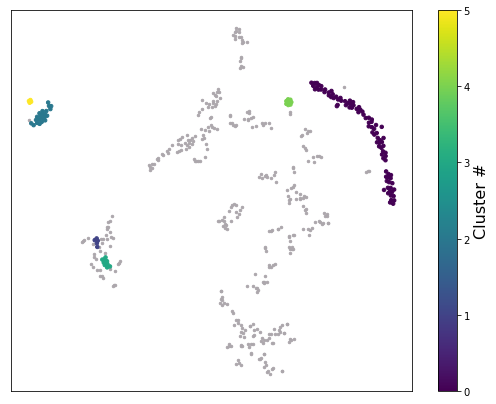

In [23]:
fig, ax = plt.subplots(figsize=(9, 7))

# Рисуем серым цветом точки, не попавшие в кластер
unclustered_index = np.where(dbscan3.labels_ < 0)
ax.scatter(
    tsne3.embedding_[unclustered_index, 0],
    tsne3.embedding_[unclustered_index, 1],
    c="#aca7ac",
    s=6,
)

# Точки, попавшие в кластер
clustered_index = np.where(dbscan3.labels_ >= 0)
cmap = ax.scatter(
    tsne3.embedding_[clustered_index, 0],
    tsne3.embedding_[clustered_index, 1],
    c=dbscan3.labels_[clustered_index],
    cmap="viridis",
    s=12,
)

ax.set_xticks([]) 
ax.set_yticks([])
cbar = fig.colorbar(cmap)
cbar.set_label("Cluster #", fontsize=16)

## Оценка распределения параметров в кластерах
Строим график распределения параметров системы уравнения для каждого кластера. Текстом выводятся средние значения параметров для кластера и их среднеквадратичное отклонение. В результате можно выбрать решение, в котором параметры распределены достаточно плотно и имеют _разумные_ значения.

В этой ячейке нужно будет изменить название сохраняемого файла `U-Trp-SMUG1-R243A-aggregated-constants.csv` на соответствующий обрабатываемым данным

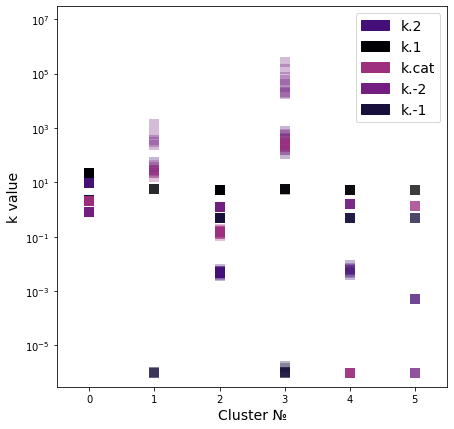

In [49]:
fig, ax = plt.subplots(figsize=(7, 7))
patches = set()
cmap = get_cmap("magma")
aggregated_constants = []

for label, sdf in data3.groupby("label"):
    entry = {"Cluster": label}
    for const_number, parameter in enumerate(data3[columns_to_clusters]):
        par_name = ".".join(parameter.split(".")[:-1])
        entry[f"{par_name} mean"] = sdf[parameter].mean()
        entry[f"{par_name} stdev"] = sdf[parameter].std()

        if par_name[0] != "k":
            continue

        # Рисуем каждую константу или респонс своим цветом
        plt.scatter(
            np.zeros(sdf[parameter].shape) + label,
            sdf[parameter],
            marker="s",
            color=cmap(const_number / len(columns_to_clusters)),
            alpha=0.3,
            linewidths=0,
            s=100,
        )
        patches.add(tuple(
            [
                cmap(const_number / len(columns_to_clusters)),
                par_name,
            ]
        ))

    aggregated_constants.append(entry)

# Настройка графика
ax.set_yscale("log")
ax.set_ylim(3e-7, 3e+7)
ax.set_xlim(
    -0.5,
    np.max(
        data3["label"].unique()
    ) + 0.5
)
ax.set_xticks(
    range(
        np.max(data3["label"].unique()) + 1
    )
)
ax.set_xlabel("Cluster №", fontsize=14)
ax.set_ylabel("k value", fontsize=14)
ax.legend(
    handles=[mpatches.Patch(color=c, label=l) for c, l in patches],
    fontsize=14
)

# Сохраняем статистику
aggregated_constants = pd.DataFrame.from_records(aggregated_constants)
aggregated_constants.to_csv(
    "U-Trp-SMUG1-R243A-aggregated-constants.csv",
    index=False,
)

In [50]:
aggregated_constants

Cluster      k.1 mean      k.1 stdev     k.-1 mean    k.-1 stdev  \
0       -1  44647.392292  141155.748416  49597.412320  1.390780e+05   
1        0     22.309947       0.000254      2.205834  1.552257e-04   
2        1      5.529262       0.036167      0.000001  1.318345e-08   
3        2      5.275831       0.000029      0.469894  6.228944e-05   
4        3      5.482933       0.037866      0.000001  2.775487e-07   
5        4      5.196430       0.000166      0.469685  1.383050e-04   
6        5      5.275457       0.000005      0.469491  1.298717e-05   

       k.2 mean     k.2 stdev     k.-2 mean     k.-2 stdev    k.cat mean  \
0  52964.050547  1.670049e+05  48232.936140  159887.272592  50595.560255   
1      9.158834  1.649101e-04      0.829520       0.000080      2.027665   
2     33.526800  1.351306e+01    589.189000     480.245334     27.827640   
3      0.004813  5.858748e-04      1.241175       0.016262      0.147402   
4    340.723556  2.086374e+02  76234.833333   85675.233978    291.780111   
5      0.005963  1.527034e-03      1.552186       0.001587      0.000001   
6      0.000502  1.029563e-08      0.000001       0.000000      1.393242   

     k.cat stdev  r(E) mean    r(E) stdev  r(E.S1) mean  r(E.S1) stdev  \
0  149171.339888   0.801448  7.784029e-02     10.315966   4.157070e+01   
1       0.000024   0.855481  1.116513e-16      0.823943   4.989775e-07   
2       9.778764   0.831275  6.786066e-03      0.794889   2.797381e-02   
3       0.016855   0.859363  4.558423e-07      0.763726   4.364358e-07   
4     132.378402   0.823267  1.705356e-03      0.740558   1.660212e-03   
5       0.000000   0.859366  6.408699e-07      0.762803   1.302470e-06   
6       0.000005   0.859365  0.000000e+00      0.763727   0.000000e+00   

   r(E.S2) mean  r(E.S2) stdev   r(E.P) mean  r(E.P) stdev  
0  1.979766e+01   2.561593e+02  1.048552e+01  5.831174e+01  
1  7.561865e-01   8.544482e-07  8.035420e-01  0.000000e+00  
2  7.500024e-07   5.366563e-12  7.836274e-01  7.272932e-03  
3  1.294778e+01   1.393222e+00  8.100000e-07  1.083707e-22  
4  7.614314e-07   3.425572e-08  7.749808e-01  1.602101e-03  
5  1.190640e+01   2.813164e+00  1.167722e+00  3.288406e-01  
6  1.160652e+02   3.201562e-03  8.100000e-07  0.000000e+00